In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
import tqdm
import glob, os, pickle
dfs=[]
path= "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/scc_tumor_data/prelim_patch_info_v2/"

for file in tqdm.tqdm(sorted(glob.glob(path + '/*.pkl'))):
    basename=os.path.basename(file).replace(".pkl","")
    df=pd.read_pickle(file)
    df['patch_index']=np.arange(df.shape[0])
    if 'scc' not in df.columns: df['scc']=0
    df['scc']=(df['scc']==1).astype(int)  
    df['ID']=basename
    dfs.append(df)
df=pd.concat(dfs)

100%|████████████████████████████████████████████████████| 95/95 [00:03<00:00, 27.84it/s]


In [3]:
from sklearn.model_selection import train_test_split

In [6]:
#TUMOR_THRESHOLD=0.2
IDs=(df.groupby(["ID"])['scc'].mean()).astype(int) #>TUMOR_THRESHOLD).astype(int)

In [7]:

train_ID,test_ID=train_test_split(IDs,stratify=IDs.values, random_state=42)
train_ID,val_ID=train_test_split(train_ID,stratify=train_ID.values, random_state=42)

In [8]:
train_val_test_slide_ids=dict(train=train_ID.index,val=val_ID.index,test=test_ID.index)

In [10]:
np.random.seed(42)
patch_dict=dict(train=df.loc[df['ID'].isin(train_val_test_slide_ids['train'])].sample(n=160000),
               val=df.loc[df['ID'].isin(train_val_test_slide_ids['val'])].sample(n=20000),
               test=df.loc[df['ID'].isin(train_val_test_slide_ids['test'])].sample(n=20000))

In [11]:
train_val_test_slide_ids={k:patch_dict[k]['ID'].unique() for k in patch_dict}

In [12]:
train_val_test_slide_ids

{'train': array(['270_A2f_ASAP_tumor_map', '352_A1d_ASAP_tumor_map',
        '364_A4b_ASAP_tumor_map', '270_A1b_ASAP_tumor_map',
        '363_A3b_ASAP_tumor_map', '7_A1d_ASAP_tumor_map',
        '110_A2b_ASAP_tumor_map', '353_A2b_ASAP_tumor_map',
        '362_A1b_ASAP_tumor_map', '365_A1b_ASAP_tumor_map',
        '352_A1i_ASAP_tumor_map', '109_A1c_ASAP_tumor_map',
        '327_A1d_ASAP_tumor_map', '352_A1h_ASAP_tumor_map',
        '364_A1b_ASAP_tumor_map', '346_a_ASAP_tumor_map',
        '352_A1g_ASAP_tumor_map', '345_a_ASAP_tumor_map',
        '281_A1f_ASAP_tumor_map', '350_A1a_ASAP_tumor_map',
        '363_A2b_ASAP_tumor_map', '370_A1b_ASAP_tumor_map',
        '343_c_ASAP_tumor_map', '367_A2b_ASAP_tumor_map',
        '354_D1b_ASAP_tumor_map', '70_A2b_ASAP_tumor_map',
        '369_A1c_ASAP_tumor_map', '341_a_ASAP_tumor_map',
        '362_A1c_ASAP_tumor_map', '342_a_ASAP_tumor_map',
        '354_A1b_ASAP_tumor_map', '112_a_ASAP_tumor_map',
        '351_A2b_ASAP_tumor_map', '343_a_ASAP_

In [13]:
df['Set']='train'
for k in train_val_test_slide_ids:
    df.loc[df["ID"].isin(train_val_test_slide_ids[k]),"Set"]=k

In [14]:

df.to_pickle("Master_Dict.pkl")

In [1]:
!nvidia-smi


Sat Nov 12 14:28:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   37C    P0    42W / 300W |      0MiB / 32768MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [16]:
for k in tqdm.tqdm(list(patch_dict.keys()),desc="train_val_test"):
    if not os.path.exists(f'cnn_model_input/{k}_data.pkl'):
        X,y=[],[]
        for name, dff in tqdm.tqdm(patch_dict[k].groupby('ID'),total=patch_dict[k]['ID'].nunique(),desc="case"):
            arr=np.load(f"/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/scc_tumor_data/prelim_patch_info/{name}.npy")
            X.append(arr[dff['patch_index'].values])
            y.append(dff['scc'].values.flatten().astype(int))
            del arr
        X=np.concatenate(X,0)
        y=np.hstack(y)
        with open(f'/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/scc_tumor_data/prelim_patch_info/{k}_data.pkl','wb') as f:
            pickle.dump(dict(X=X,y=y,patch_info=patch_dict[k]),f,pickle.HIGHEST_PROTOCOL)

train_val_test: 100%|█████████████████████████████████████| 3/3 [23:01<00:00, 460.38s/it]


In [13]:
from keras.callbacks import ReduceLROnPlateau
lrr=ReduceLROnPlateau (monitor='val_acc', factor=.01, patience=3, min_lr=1e-5)

2022-11-12 13:21:52.333085: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from pathpretrain.train_model import train_model
train_model(inputs_dir="/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/cnn_model_input_1223/",
                learning_rate=1e-3,
                n_epochs=20,
                batch_size=256,
                model_save_loc='/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/cnn_model_1223.pkl',
                verbose=2,
                class_balance=True,
                predict=False,
                pickle_dataset=True)

{'train': <pathpretrain.datasets.PickleDataset object at 0x2ab9dd0c4af0>, 'val': <pathpretrain.datasets.PickleDataset object at 0x2ab9dd0c4670>}
ResNet(
  (features): Sequential(
    (init_block): ResInitBlock(
      (conv): ConvBlock(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace=True)
      )
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (stage1): Sequential(
      (unit1): ResUnit(
        (body): ResBottleneck(
          (conv1): ConvBlock(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activ): ReLU(inplace=True)
          )
          (conv2): ConvBlock(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

/dartfs-hpc/rc/home/3/f006n33/anaconda3/envs/hiss/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Epoch 0[0/625] Time:0.708, Train Loss:0.7055618166923523
Epoch 0[1/625] Time:0.704, Train Loss:3.463738441467285
Epoch 0[2/625] Time:0.703, Train Loss:1.5663138628005981
Epoch 0[3/625] Time:0.704, Train Loss:0.7297398447990417
Epoch 0[4/625] Time:0.703, Train Loss:0.9673916697502136
Epoch 0[5/625] Time:0.703, Train Loss:0.7107248902320862
Epoch 0[6/625] Time:0.703, Train Loss:0.6107208728790283
Epoch 0[7/625] Time:0.741, Train Loss:0.774010419845581
Epoch 0[8/625] Time:0.694, Train Loss:0.6371622681617737
Epoch 0[9/625] Time:0.695, Train Loss:0.5472089052200317
Epoch 0[10/625] Time:0.695, Train Loss:0.5309845209121704
Epoch 0[11/625] Time:0.703, Train Loss:0.6355748772621155
Epoch 0[12/625] Time:0.708, Train Loss:0.7202491760253906
Epoch 0[13/625] Time:0.703, Train Loss:0.5752288103103638
Epoch 0[14/625] Time:0.693, Train Loss:0.6069890260696411
Epoch 0[15/625] Time:0.693, Train Loss:0.6988580822944641
Epoch 0[16/625] Time:0.703, Train Loss:0.5875471234321594
Epoch 0[17/625] Time:0.706

ResNet(
  (features): Sequential(
    (init_block): ResInitBlock(
      (conv): ConvBlock(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace=True)
      )
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (stage1): Sequential(
      (unit1): ResUnit(
        (body): ResBottleneck(
          (conv1): ConvBlock(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activ): ReLU(inplace=True)
          )
          (conv2): ConvBlock(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (a

In [21]:
!sleep 3600

^C


In [1]:
from pathpretrain.predict import predict

In [4]:
predict(inputs_dir='/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/cnn_model_input_1223/',
                batch_size=64,
                model_save_loc="/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/cnn_model_1223.pkl",
                predict_set='test',
                pickle_dataset=True)

{'train': <pathpretrain.datasets.PickleDataset object at 0x2ac4284cd3a0>, 'val': <pathpretrain.datasets.PickleDataset object at 0x2ab9dccb10a0>, 'test': <pathpretrain.datasets.PickleDataset object at 0x2ab9dd0c4cd0>}
ResNet(
  (features): Sequential(
    (init_block): ResInitBlock(
      (conv): ConvBlock(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace=True)
      )
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (stage1): Sequential(
      (unit1): ResUnit(
        (body): ResBottleneck(
          (conv1): ConvBlock(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activ): ReLU(inplace=True)
          )
          (conv2): Conv

313it [00:37,  8.25it/s]                                                                 


In [2]:
import torch
from scipy.special import softmax
from sklearn.metrics import roc_auc_score
predictions=torch.load("/dartfs-hpc/rc/home/3/f006n33/predictions.pkl")
predictions['pred']=softmax(predictions['pred'])
roc_auc_score(predictions['true'],predictions['pred'][:,1])

0.9509396065119922

In [3]:
print (predictions)

{'pred': array([[1.5933154e-05, 3.9055425e-07],
       [2.5007705e-05, 2.4779158e-07],
       [3.6103197e-06, 1.7127517e-06],
       ...,
       [9.8847986e-06, 6.2929161e-07],
       [8.9098858e-06, 6.9818577e-07],
       [8.8561387e-07, 6.9204730e-06]], dtype=float32), 'true': array([0, 0, 0, ..., 0, 0, 1])}


In [4]:
import sklearn.metrics as metrics
# fpr and tpr of all thresohlds
true = predictions['true']
preds = predictions['pred'][:,1]
fpr, tpr, threshold = metrics.roc_curve(true, preds)
roc_auc = metrics.auc(fpr, tpr)



In [6]:

import matplotlib.pyplot as plt
plt.title('AUC-ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

/scratch/ipykernel_86851/2083274585.py:10: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [7]:
plt.show()

/scratch/ipykernel_86851/2122436968.py:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [2]:
!pip uninstall -y pathpretrain
!pip install git+https://github.com/jlevy44/PathPretrain

Found existing installation: pathpretrain 0.1
Uninstalling pathpretrain-0.1:
  Successfully uninstalled pathpretrain-0.1
  Cloning https://github.com/jlevy44/PathPretrain to /scratch/pip-req-build-b9lj_yhd
  Running command git clone --quiet https://github.com/jlevy44/PathPretrain /scratch/pip-req-build-b9lj_yhd
  Resolved https://github.com/jlevy44/PathPretrain to commit 6b1172c055c45fb01d80ad02ed6d334247c24e1b
  Preparing metadata (setup.py) ... done
  Created wheel for pathpretrain: filename=pathpretrain-0.1-py3-none-any.whl size=23572 sha256=d2ff3bbeb61701a35c06694e40ae34db795074ec3ccb5f5ae9c515d64885be18
  Stored in directory: /scratch/pip-ephem-wheel-cache-xtr84xbr/wheels/95/0c/6f/7498ced330de24503d0b19e7997fa3290b64e695b46d04ed61
Successfully built pathpretrain


In [3]:
from pathpretrain.embed import generate_embeddings

In [12]:
generate_embeddings(patch_info_file="/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/scc_tumor_data/prelim_patch_info_v2/109_A1c_ASAP_tumor_map.pkl",
                   image_file="/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/scc_tumor_data/prelim_patch_info/109_A1c_ASAP_tumor_map.npy",
                   model_save_loc="/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/cnn_model.pkl",
                   architecture='resnet50',
                   num_classes=2,
                   image_stack=True)

1291it [01:28, 14.63it/s]                                                          


In [35]:
import torch
embeddings=torch.load("/dartfs-hpc/rc/home/3/f006n33/cnn_embeddings/112_b_ASAP_tumor_map.pkl")
import umap
z=umap.UMAP(random_state=42, n_components=2).fit_transform(embeddings['embeddings'])

In [36]:
%matplotlib inline

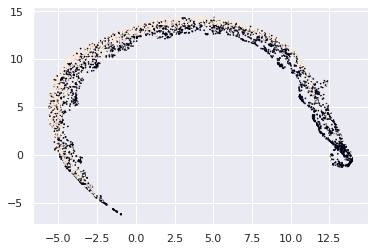

In [37]:
import matplotlib, matplotlib.pyplot as plt
plt.scatter(z[:,0],z[:,1],c=embeddings['patch_info']['scc'],s=0.5)

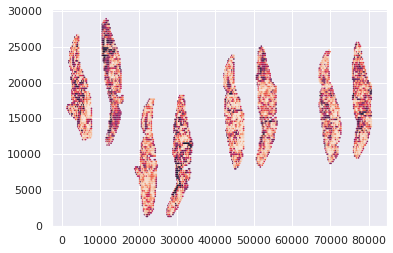

In [38]:
plt.scatter(embeddings['patch_info']['x'],embeddings['patch_info']['y'],c=z[:,1], s=0.4)

In [11]:
from pathpretrain.embed import generate_embeddings
for ID in df:
    generate_embeddings(patch_info_file=f"/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/scc_tumor_data/prelim_patch_info_v2/{ID}.pkl",
                        image_file=f"/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/scc_tumor_data/prelim_patch_info/{ID}.npy",
                        model_save_loc='cnn_model.pkl',
                        architecture="resnet50",
                        num_classes=3,
                        image_stack=True)

1291it [01:30, 14.30it/s]                                                       
515it [00:31, 16.53it/s]                                                        
532it [00:34, 15.37it/s]                                                        
576it [00:37, 15.55it/s]                                                        
100%|█████████████████████████████████████████| 558/558 [00:32<00:00, 17.02it/s]
195it [00:11, 17.34it/s]                                                        
214it [00:12, 17.29it/s]                                                        
500it [00:31, 15.77it/s]                                                        
654it [00:42, 15.36it/s]                                                        
457it [00:26, 17.12it/s]                                                        
462it [00:26, 17.17it/s]                                                        
486it [00:27, 17.64it/s]                                                        
668it [00:42, 15.62it/s]    